In [35]:
import numpy as np
import pandas as pd
import xarray as xr

import plotly.express as px

# Temperature index models

## Naive first approach

In [5]:
degree_day_factor = 8.0  # mm/day/degree celsius
temperature_plus = 3.0  # degree celsius
delta_time = 4  # day

melt = degree_day_factor * temperature_plus * delta_time
print(f"melt of snow for {delta_time} is {melt} mm")

melt of snow for 4 is 96.0 mm


Now lets look at the cumulative melt over 10 days

In [6]:
n = 11
days = range(1, n)
melt = 0

for day in days:
    melt = melt + degree_day_factor * temperature_plus * delta_time
    print(f"cummulative melt of snow for {day} is {melt:.2f} mm")

cummulative melt of snow for 1 is 96.00 mm
cummulative melt of snow for 2 is 192.00 mm
cummulative melt of snow for 3 is 288.00 mm
cummulative melt of snow for 4 is 384.00 mm
cummulative melt of snow for 5 is 480.00 mm
cummulative melt of snow for 6 is 576.00 mm
cummulative melt of snow for 7 is 672.00 mm
cummulative melt of snow for 8 is 768.00 mm
cummulative melt of snow for 9 is 864.00 mm
cummulative melt of snow for 10 is 960.00 mm


ok a bit nicer, but the Temperature is still constant. Now use a random tempearature list form -5 to +10

In [7]:
n = 11
days = range(1, n)

np.random.seed(42)
temperatures = np.random.uniform(-5, 10, len(days))
melt = 0

for day in days:
    temperature_plus = temperatures[day - 1]
    melt = melt + degree_day_factor * temperature_plus * delta_time
    print(
        f"cummulative melt of snow for {day} with {temperature_plus:.2f}°C is {melt:.2f} mm"
    )

cummulative melt of snow for 1 with 0.62°C is 19.78 mm
cummulative melt of snow for 2 with 9.26°C is 316.12 mm
cummulative melt of snow for 3 with 5.98°C is 507.48 mm
cummulative melt of snow for 4 with 3.98°C is 634.84 mm
cummulative melt of snow for 5 with -2.66°C is 549.72 mm
cummulative melt of snow for 6 with -2.66°C is 464.60 mm
cummulative melt of snow for 7 with -4.13°C is 332.48 mm
cummulative melt of snow for 8 with 7.99°C is 588.25 mm
cummulative melt of snow for 9 with 4.02°C is 716.78 mm
cummulative melt of snow for 10 with 5.62°C is 896.66 mm


In [8]:
n = 11
days = range(1, n)

np.random.seed(42)
temperatures = np.random.uniform(-5, 10, len(days))
melt = 0

for day in days:
    current_temperature = temperatures[day - 1]
    temperature_plus = np.maximum(current_temperature, 0)
    melt = melt + degree_day_factor * temperature_plus * delta_time
    print(
        f"cummulative melt of snow for {day} with {current_temperature:.2f}°C is {melt:.2f} mm"
    )

cummulative melt of snow for 1 with 0.62°C is 19.78 mm
cummulative melt of snow for 2 with 9.26°C is 316.12 mm
cummulative melt of snow for 3 with 5.98°C is 507.48 mm
cummulative melt of snow for 4 with 3.98°C is 634.84 mm
cummulative melt of snow for 5 with -2.66°C is 634.84 mm
cummulative melt of snow for 6 with -2.66°C is 634.84 mm
cummulative melt of snow for 7 with -4.13°C is 634.84 mm
cummulative melt of snow for 8 with 7.99°C is 890.60 mm
cummulative melt of snow for 9 with 4.02°C is 1019.14 mm
cummulative melt of snow for 10 with 5.62°C is 1199.01 mm


## actual use of Python

In [9]:
def degree_day_model(
    temperatures: np.array, degree_day_factor: float, threshold_temp: float = 0.0
) -> np.array:
    """
    Estimate daily melt amount using the Degree-Day Model.

    Parameters:
    temperatures (numpy.array): Array of daily mean air temperatures (°C).
    degree_day_factor (float): Degree-day factor (mm °C^-1 day^-1).
    threshold_temp (float): Threshold temperature above which melting occurs (°C). Default is 0.0°C.

    Returns:
    numpy.array: Array of daily melt amounts (mm).
    """
    # Calculate positive temperature differences (temperatures above the threshold)
    positive_temperatures = np.maximum(temperatures - threshold_temp, 0)

    # Calculate daily melt amounts
    daily_melt = positive_temperatures * degree_day_factor

    return daily_melt

In [10]:
temperatures = np.array([-3.2, -1.1, 0.0, 2.2, 5.1, 3.0, 0.0, -2.0])

In [11]:
ddf = 8.0
melt_amounts = degree_day_model(temperatures, degree_day_factor=ddf)

In [12]:
melt = pd.DataFrame(melt_amounts, index=temperatures, columns=[f"ddf = {ddf}"])

<Axes: >

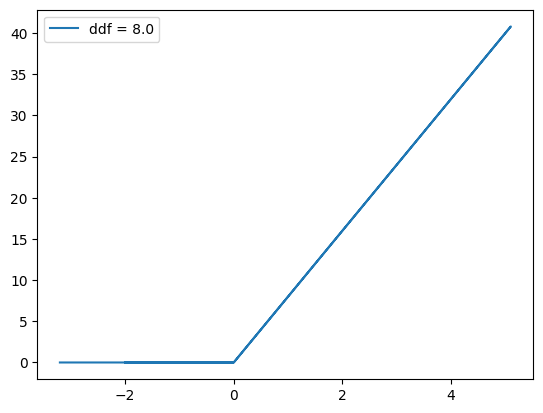

In [13]:
melt.plot()

* change the function to use SI base units
* plot the curve for different degree day factors.
* compare snow and ice: 2.5 to 11.6 mm/(day K)  for snow 6.6 to 20.0 mm/(day K) for ice,

What is the total amount of melt in mm over all days

In [14]:
melt["ddf = 8.0"].sum()

82.4

## Spatial distributed version

In [15]:
number_of_rows = 25
number_of_columns = 10

In [16]:
np.random.seed(42)
temperatures = np.random.uniform(-5, 10, (number_of_rows, number_of_columns))

In [17]:
melt_amounts_distributed = degree_day_model(temperatures, degree_day_factor=ddf)

In [18]:
melt_amounts_distributed

array([[ 4.94481426, 74.08571677, 47.83927302, 31.8390181 ,  0.        ,
         0.        ,  0.        , 63.94113749, 32.13380141, 44.96870934],
       [ 0.        , 76.38918226, 59.8931169 ,  0.        ,  0.        ,
         0.        ,  0.        , 22.9707718 , 11.83340224,  0.        ],
       [33.42234737,  0.        ,  0.        ,  3.9634212 , 14.72839811,
        54.22111537,  0.        , 21.70813261, 31.08974826,  0.        ],
       [32.90538223,  0.        ,  0.        , 73.86626447, 75.87584397,
        57.00768177,  0.        ,  0.        , 42.10796318, 12.81829925],
       [ 0.        , 19.42122921,  0.        , 69.11844825,  0.        ,
        39.50267412,  0.        , 22.40816254, 25.60523352,  0.        ],
       [76.35015533, 53.0159388 , 72.73987299, 67.37928205, 31.74799746,
        70.6249082 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 6.64127476,  0.        , 59.4485011 ,  2.8103992 ,  0.        ,
        25.12352998,  0.        , 56.26363769

In [19]:
distribued_melt_df = pd.DataFrame(melt_amounts_distributed)
distribued_melt_df

,0,1,2,3,4,5,6,7,8,9
0,4.944814,74.085717,47.839273,31.839018,0.000000,0.000000,0.000000,63.941137,32.133801,44.968709
1,0.000000,76.389182,59.893117,0.000000,0.000000,0.000000,0.000000,22.970772,11.833402,0.000000
2,33.422347,0.000000,0.000000,3.963421,14.728398,54.221115,0.000000,21.708133,31.089748,0.000000
3,32.905382,0.000000,0.000000,73.866264,75.875844,57.007682,0.000000,0.000000,42.107963,12.818299
4,0.000000,19.421229,0.000000,69.118448,0.000000,39.502674,0.000000,22.408163,25.605234,0.000000
5,76.350155,53.015939,72.739873,67.379282,31.747997,70.624908,0.000000,0.000000,0.000000,0.000000
6,6.641275,0.000000,59.448501,2.810399,0.000000,25.123530,0.000000,56.263638,0.000000,78.426432
7,52.669372,0.000000,0.000000,57.855371,44.822881,47.480860,52.552442,0.000000,3.015887,0.000000
8,63.572411,34.795775,0.000000,0.000000,0.000000,0.000000,47.552741,36.506897,66.465529,16.665791
9,0.000000,45.589374,51.294206,27.353264,52.516062,19.255472,22.727940,11.304922,0.000000,0.000000


In [28]:
px.imshow(
    distribued_melt_df,
    origin="lower",
    labels=dict(x="Column", y="Row"),
    title="Plot without Interpolation",
)

## Now with space and time

In [55]:
number_of_rows = 25
number_of_columns = 10
number_of_days = 10

In [56]:
np.random.seed(42)
temperatures = np.random.uniform(
    -5, 10, (number_of_rows, number_of_columns, number_of_days)
)

In [57]:
data_array = xr.DataArray(temperatures, dims=("row", "column", "day"))

In [58]:
dataset = xr.Dataset({"temperature": data_array})

In [59]:
dataset

<xarray.Dataset>
Dimensions:      (row: 25, column: 10, day: 10)
Dimensions without coordinates: row, column, day
Data variables:
    temperature  (row, column, day) float64 0.6181 9.261 5.98 ... 9.711 1.114

In [60]:
dataset["daily_melt"] = degree_day_model(dataset["temperature"], degree_day_factor)

In [61]:
dataset

<xarray.Dataset>
Dimensions:      (row: 25, column: 10, day: 10)
Dimensions without coordinates: row, column, day
Data variables:
    temperature  (row, column, day) float64 0.6181 9.261 5.98 ... 9.711 1.114
    daily_melt   (row, column, day) float64 4.945 74.09 47.84 ... 77.69 8.91

In [63]:
import plotly.graph_objects as go

ds = dataset

In [64]:
fig = go.Figure()

# Assuming 'row' and 'column' are your spatial dimensions and 'day' is the time dimension
for day in range(ds.dims["day"]):
    fig.add_trace(
        go.Heatmap(
            z=ds["daily_melt"].isel(day=day),
            x=ds["column"],
            y=ds["row"],
            showscale=False,
        )
    )

# Make 10th frame visible
# fig.data[9].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}, {"title": "Day: " + str(i)}],
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(active=10, currentvalue={"prefix": "Day: "}, steps=steps)]

fig.update_layout(sliders=sliders)

# Set up the layout
fig.update_layout(title="Daily Melt Animation", width=600, height=600, autosize=False)

fig.show()

/var/folders/yg/ztd1f9dj7zq2_ndrl23s9c800000gn/T/ipykernel_10471/1353216321.py:4: FutureWarning:

The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.

